# 8.2 Mathematical tools for image formation. Homogeneous transformations


Homogeneous (also called projective) transformations are linear transformations (i.e. matrix multiplications) **between homogeneous coordinates** (vectors). Such coordinates are obtained from Cartesian (inhomogeneous) vectors by **extending them with a non-negative number** (typically 1, for convenience).

Although we are going to explain homogeneous transformations using the 3D space, **this is generalizable to any other number of dimensions**.

A 3D vector (or a 3D point) in **inhomogeneous coordinates** looks like:

$$\mathbf{x} = \begin{bmatrix} x \\ y \\ z \end{bmatrix} \in \mathbb{R}^3$$

while the same vector in **homogeneous coordinates** has the form (note the tilde in the notation):

$$\mathbf{\tilde{x}} = \begin{bmatrix} x \\ y \\ z \\ 1 \end{bmatrix} \equiv \begin{bmatrix} \lambda x \\ \lambda y \\ \lambda z \\ \lambda \end{bmatrix} \in \mathbb{R}^4$$

We can go back by dividing the three first coordinates by the fourth:$\\[5pt]$

$$\mathbf{\tilde{x}} = \begin{bmatrix} \lambda x \\ \lambda y \\ \lambda z \\ \lambda \end{bmatrix} \Rightarrow \mathbf{x} = \begin{bmatrix} x/\lambda \\ y/\lambda \\ z/\lambda \end{bmatrix} \in \mathbb{R}^3$$

This way, the family of homogeneous vectors with $\lambda \neq 0$ represents the same point in $\mathbb{R}^3$, since $\lambda$ doesn't affect. Another consequence of $\lambda$ is that **any transformation in homogeneous coordinates holds for any scaled matrix**:
  
$$
\begin{bmatrix} x_1' \\ x_2' \\ x_3' \\ x_4' \end{bmatrix} 
= 
\begin{bmatrix} p_{11} & p_{12} & p_{13} & p_{14} \\ p_{21} & p_{22} & p_{23} & p_{24} \\ p_{31} & p_{32} & p_{33} & p_{34} \\ p_{41} & p_{42} & p_{43} & p_{44} \end{bmatrix} 
\begin{bmatrix} \lambda x_1 \\ \lambda x_2 \\ \lambda x_3 \\ \lambda \end{bmatrix} 
= 
\lambda 
\begin{bmatrix} p_{11} & p_{12} & p_{13} & p_{14} \\ p_{21} & p_{22} & p_{23} & p_{24} \\ p_{31} & p_{32} & p_{33} & p_{34} \\ p_{41} & p_{42} & p_{43} & p_{44} \end{bmatrix}
\begin{bmatrix} x_1 \\ x_2 \\ x_3 \\ 1 
\end{bmatrix} 
$$

Then, the following transformations are equivalent:

$$
\begin{bmatrix} 1 & -3 & 2 & 5 \\ 4 & 2 & 1 & 2 \\ 4 & -1 & 0 & 2 \\ -6 & 2 & 1 & 2 
\end{bmatrix} 
\equiv 
\lambda 
\begin{bmatrix} 1 & -3 & 2 & 5 \\ 4 & 2 & 1 & 2 \\ 4 & -1 & 0 & 2 \\ -6 & 2 & 1 & 2 
\end{bmatrix}
$$

**This indetermination is typically handled by fixing one entry of the matrix**, (e.g. $p_{44} = 1$). Also, these matrices must be non-singular (Rank = 4).

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as stats
from ipywidgets import interact, fixed, widgets
from mpl_toolkits.mplot3d import Axes3D
from math import sin, cos, radians
%matplotlib widget

matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
images_path = './images/'

## 8.2.1 Why do we want this? Reason one

Now that we know how homogenous coordinates and homogenous transformations works, it's time for understanding **why this is interesting**.

For now, we were performing complete transformations (rotations and translations) by using a rotation matrix and adding a translation vector to the rotated points ($\mathbf{p}' = \mathbf{R}\mathbf{p} + \mathbf{t}$).

The problem of this transformation is that the **concatenation of transformations** when a sequence of transformations has to be done becomes a mess:

$\hspace{2cm} \mathbf{p}' = \mathbf{R}_1\mathbf{p}+\mathbf{t}_1 \\ \hspace{2cm} \mathbf{p}'' = \mathbf{R}_2\mathbf{p}' + \mathbf{t}_2 = \mathbf{R}_2(\mathbf{R}_1\mathbf{p}+\mathbf{t}_1) + \mathbf{t}_2 = \mathbf{R}_2\mathbf{R}_1\mathbf{p} + \mathbf{R}_2\mathbf{t}_1 + \mathbf{t}_2$

In the context of our problem, every time we move the camera we have to concatenate a new transformation. Imagine this in a first-person videogame, where a transformation of the coordinate system is needed in every frame. In just a second more than 60 concatenations should be computed!

**What happens if we use homogenous coordinates?**

We can express a transformation consisting of a rotation + translation using only a matrix multiplication:

$$ \mathbf{\tilde{p}}' = \mathbf{T}_1\mathbf{\tilde{p}} \Rightarrow \begin{bmatrix} x' \\ y' \\ z' \\ 1 \end{bmatrix} = \begin{bmatrix} r_{11} & r_{12} & r_{13} & t_x\\ r_{21} & r_{22} & r_{23} & t_y \\ r_{31} & r_{32} & r_{33} & t_z \\ 0 & 0 & 0 & 1 \end{bmatrix} \begin{bmatrix} x \\ y \\ z \\ 1 \end{bmatrix} = \begin{bmatrix} r_{11}x + r_{12}y + r_{13}z + t_x \\ r_{21}x + r_{22}y + r_{23}z + t_y \\ r_{31}x + r_{32}y + r_{33}z + t_z \\ 0x + 0y + 0z + 1 \end{bmatrix} = \begin{bmatrix} r_{11}x + r_{12}y + r_{13}z \\ r_{21}x + r_{22}y + r_{23}z \\ r_{31}x + r_{32}y + r_{33}z \\ 1 \end{bmatrix} +  \begin{bmatrix} t_x \\ t_y \\ t_z \\ 0 \end{bmatrix}$$

Note that the 3$\times$3 left-top submatrix of the $\mathbf{T}_1$ matrix is a rotation matrix while the last column contains the desired translation. 
This is the main reason for using homogeneous coordinates, look **how concatenation is applied now!**

$\hspace{02cm}  \mathbf{\tilde{p}}' = \mathbf{T}_1\mathbf{\tilde{p}} \\
 \hspace{2cm}  \mathbf{\tilde{p}}'' = \mathbf{T}_2\mathbf{\tilde{p}}' = \mathbf{T}_2\mathbf{T}_1\mathbf{\tilde{p}}$
 
**Concatenation becomes much easier**, being only consecutive matrix multiplications (remember that, nowadays, matrix multiplications are very fast using GPUs).

**Let's play a bit with homogeneous coordinates**. We are going to apply a homogenous transformation to a 3D object (a set of 3D-points, in fact). For this, we have defined `data`$\in \mathbb{R}^4$, a **matrix containing more than 3k points in homogenous coordinates**:

Number of points: 3375.0


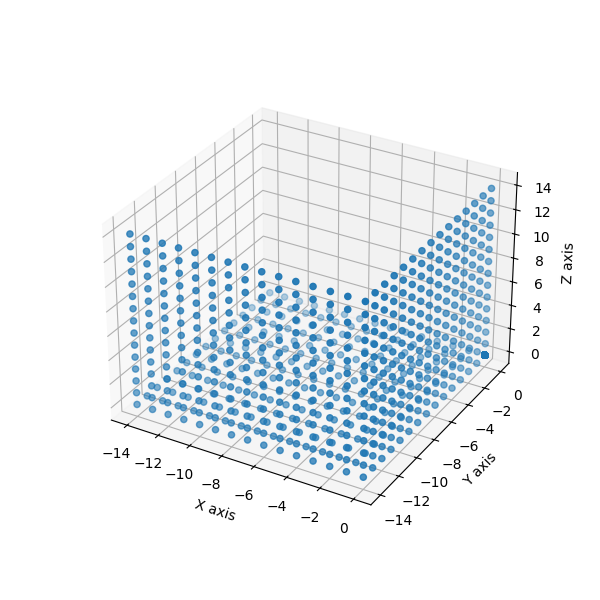

In [2]:
# Load data
data = np.load("./data/data.npy")
print('Number of points:', data.size/4)

# Create figure
fig = plt.figure()

# Prepare figure for 3D data
ax = plt.axes(projection='3d') 

# Name axes
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

# Plot points
ax.scatter(data[0,:], data[1,:], data[2,:]);

## **<span style="color:green"><b><i>ASSIGNMENT 1: Homogeneous transformations for the win</i></b></span>**

Now, create a new method called `apply_homogeneous_transformation()` that builds a homogeneous matrix from some *yaw*, *pitch* and *roll* values as well as a translation vector and applies it to the input data matrix `data`. *Note that we are not transforming vectors, but points, so use [`scatter()`](https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html) instead of `quiver()`.*

Notice that opposite to the euclidean case, here both rotation and translation are applied just with one matrix multiplication! (`t` in the following code).

Recall the matrices defining the elemental rotations:

$\hspace{2cm}\mathbf{R}_z(\theta) = \begin{bmatrix} cos\theta & -sin\theta & 0 \\ sin\theta & cos\theta & 0 \\ 0 & 0 & 1 \end{bmatrix} \hspace{1cm} \mathbf{R}_y(\theta) = \begin{bmatrix} cos\theta & 0 & sin\theta \\ 0 & 1 & 0 \\ -sin\theta & 0 & cos\theta \end{bmatrix} \hspace{1cm} \mathbf{R}_x(\theta) = \begin{bmatrix} 1 & 0 & 0 \\ 0 & cos\theta & -sin\theta \\ 0 & sin\theta & cos\theta \end{bmatrix}\\[5pt]$


In [3]:
# ASSIGNMENT 7
def apply_homogeneous_transformation(data, yaw, pitch, roll, translation):
    """ Apply a linear transformation to a set of 3D-vectors and plot them
        
        Args:
            data: Input set of points to transform
            yaw: Degrees to rotate the coordinate system around the 'Z' axis 
            pitch: Degrees to rotate the coordinate system around the 'Y' axis 
            roll: Degrees to rotate the coordinate system around the 'X' axis 
            translation: Column vector containing the translation for each axis
    """   
    # Write your code here!
    
    # Transform to radians
    yaw = radians(yaw)
    pitch = radians(pitch)
    roll = radians(roll)
    
    # Construct rotation matrices
    Rx = np.array([[1,0,0], [0,cos(roll),-sin(roll)], [0,sin(roll),cos(roll)]])
    Ry = np.array([[cos(pitch),0,sin(pitch)], [0,1,0], [-sin(pitch),0,cos(pitch)]])
    Rz = np.array([[cos(yaw),-sin(yaw),0], [sin(yaw),cos(yaw),0], [0,0,1]])
    
    # Combine rotation matrices
    R = Rz@Ry@Rx
    
    # Create homogenous transformation matrix
    t = np.zeros((4,4))
    t[0:3,0:3] = R
    t[0:3,3] = translation
    t[3,3] = 1

    transformed = t@data
    
    # Create figure
    fig = plt.figure()

    # Prepare figure for 3D data
    ax = plt.axes(projection='3d') 

    # Name axes
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')

    # Plot points
    ax.scatter(transformed[0,:], transformed[1,:], transformed[2,:]);

Now apply the following transformation to the object previously loaded:

- **Yaw** rotation: 45 degrees
- **Pitch** rotation: -60 degrees
- **Roll** rotation: 20 degrees
- **Translation**:
    - $X$-axis: 20 units 
    - $Y$-axis: 20 units
    - $Z$-axis: 40 units

Remember that this is going to be performed only using a homogeneous transformation (one unique matrix multiplication)!

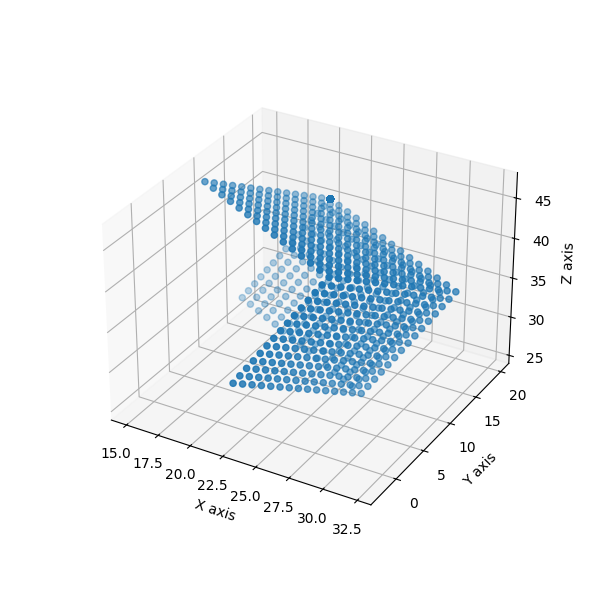

In [4]:
# Load data
data = np.load("./data/data.npy")

# Apply transformation
apply_homogeneous_transformation(data, 45, -60, 20, [20,20,40])

<font color='blue'>**Expected output:**  </font>

<img src="./images/example_transformation_5b.png" width="500" align="left"/>
<img src="./images/blank.png" width="100" align="rigth"/>

By doing these transformations, our graphic engine could represent moving objects in the `WORLD` when the player is still (e.g. flying birds, cars, other players, etc.). 

### Checking execution time

Just as a curiosity, let's check how much time is required by python to apply a transformation in both euclidean and homogeneous coordinates. *Note: take care with the length, if it is too large it could freeze your computer!*

In [5]:
# Set the number of points to transform
length = 6000000 

# Prepare data in Euclidean coordinates
Pts = np.random.rand(3,length)
R = np.random.rand(3,3)
T = np.random.rand(3,1)

# Prepare data in Homogeneous coordinates
Ones = np.ones(length)
Pts_H = np.row_stack((Pts,Ones))
T_H = np.random.rand(4,4)

import time

# Apply euclidean transformation
start_time = time.time()
res = R@Pts+T
print("Time spent with Euclidean tranformation: %s seconds ---" % (time.time() - start_time))

# Apply Homogeneous transformation
start_time = time.time()
res = T_H@Pts_H
print("Time spent with Homogeneous tranformation: %s seconds ---" % (time.time() - start_time))

Time spent with Euclidean tranformation: 0.06531763076782227 seconds ---
Time spent with Homogeneous tranformation: 0.04298901557922363 seconds ---


## **<span style="color:green"><b><i>ASSIGNMENT 2: How the player sees the world</i></b></span>**

One final example, consider the following image, in where our character Joel is looking at a dystopian, post-apocalyptic scenario. 

<img src="./images/tlou.png" width="1200" align="center"/>

The `WORLD` reference system is displayed in orange and labeled with {$\mathbf{W}$} while the reference system of the character's view is displayed in red and labeled as {$\mathbf{C}$}. We know that:

- the position and orientation of {$\mathbf{C}$} w.r.t. {$\mathbf{W}$} is given by a *yaw* angle of -45º, a *roll* angle of -90 and a translation of \[0.0,-4.0,1.2\] meters in \[$x$,$y$,$z$\] axes, respectively, and
- the coordinates of the point $\mathbf{p}^W$ in the world are \[30.0,1.0,0.5\] meters. 

**Could you compute** what are its coordinates w.r.t our character's point of view in homogeneous coordinates ($\tilde{\mathbf{p}}^C$)? In other words, we have to build the homogeneous transformation $\mathbf{T}$ that produces $\mathbf{\tilde{p}}^C = \mathbf{T}\mathbf{\tilde{p}}^W$. As we will see in future notebooks, knowing such coordinates is vital to get the position of the 3D point **in the image** that Joel would see if this game were in first-person (fortunately it's not!).

In [6]:
# ASSIGNMENT 8
# Write your code here!
p = np.array([30,1,0.5,1])
p = np.vstack(p)

# Transform to radians
yaw = radians(-45)
pitch = radians(0)
roll = radians(-90)

# Construct rotation matrices
Rx = np.array([[1,0,0], [0,cos(roll),-sin(roll)], [0,sin(roll),cos(roll)]])
Ry = np.array([[cos(pitch),0,sin(pitch)], [0,1,0], [-sin(pitch),0,cos(pitch)]])
Rz = np.array([[cos(yaw),-sin(yaw),0], [sin(yaw),cos(yaw),0], [0,0,1]])

# Combine rotation matrices
R = Rz@Ry@Rx

# Create homogenous transformation matrix
t = np.zeros((4,4))
t[0:3,0:3] = R
t[0:3,3] = np.array([0,-4,1.2])
t[3,3] = 1

transformed = np.linalg.inv(t) @ p
print(transformed)

[[17.67766953]
 [ 0.7       ]
 [24.74873734]
 [ 1.        ]]


<font color='blue'>**Expected output (homogeneous):**  </font> 

    [[17.67766953]
     [ 0.7       ]
     [24.74873734]
     [ 1.        ]]

### <font color="blue"><b><i>Thinking about it (1)</i></b></font>

**Now you are in a good position to answer these questions:**

- What is the length of a 3D cartesian vector in homogeneous coordinates?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>La longitud es 4, uno más que en coordenadas cartesianas, ya que se usa un elemento más, el factor de escala, que normalmente es 1.</i></p>
    
- How many operations do you need to transform a point from the world frame to the camera one using euclidean coordinates?  and using homogeneous coordinates?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Usando coodenadas euclideas necesitas aplicar una multiplicación de matrices 3x3 (multiplicar las 3 matrices de rotación), y luego al vector de coordenadas aplicarle esa rotación (otra multiplicación de matrices) y la traslación (suma). Usando coordenadas homogéneas necesitamos de nuevo la multiplicación de las matrices de rotación, y multiplicar el vector de origen con la matriz de transformación que contiene la rotación y la traslación.</i></p>
    
- Explain the difference in the execution time when using the two types of transformations. 

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Observamos que hacer la transformación usando coordenadas homogéneas es más rápido que hacerlo con euclídeas.</i></p>
    
- Why are the rotations applied in that order? Could they have been applied differently?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>No se pueden hacer de otra forma, ya que la multiplicación de matrices no es conmutativa y daría un resultado direfente.</i></p>

## 8.2.2 Why do we want this? Reason two

There is another reason justifying the utilization of homogeneous coordinates when dealing with transformations: they result in a natural model for the camera, since points in the image plane are projection rays in $\mathbb{R}^3$.

**In 1D:**

- Cartesian coordinates: $x=x_1=3$.
- Homogeneous coordinates: $ x = \begin{bmatrix}3 \\ 1\end{bmatrix} \equiv \begin{bmatrix}6 \\ 2\end{bmatrix} \equiv \begin{bmatrix}3k \\ k\end{bmatrix}, \ \ k \neq 0$

All the points in homogeneous coordinates represents the same point in cartesians since $x=x_1/x_2=3$.

**In 2D:**

- Cartesian coordinates: $x=\begin{bmatrix}x_1 \\ x_2\end{bmatrix} \in \mathbb{R}^2$.
- Homogeneous coordinates: $ x = k\begin{bmatrix}x_2 \\ x_1 \\ 1\end{bmatrix}, \ \ k \neq 0$

So in homogeneous coordinates, a point in the plane $\mathbb{R}^2$ transforms to a line passing through the origin in a reference frame parallel to the image plane (perpendicular to $x_3$).

The following code illustrates this for a 1D point.

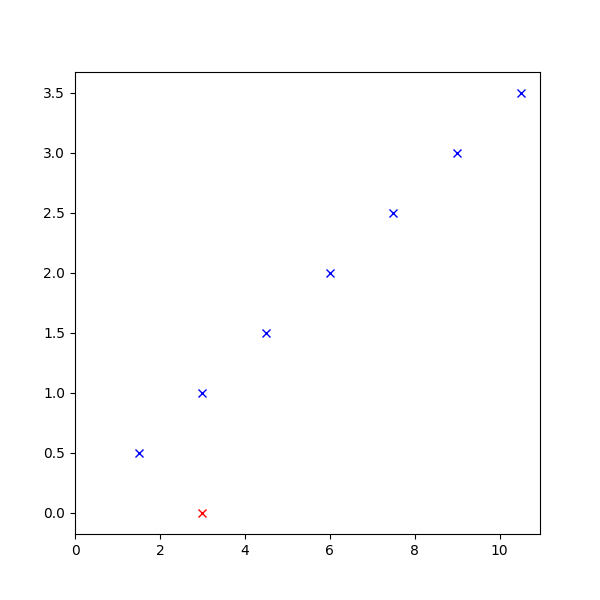

In [7]:
# 1D point
x1 = 3
plt.figure()
plt.plot(x1,0,'rx')

# Point in homogeneous
x = np.array([3,1])

# Equivalent points by multiplying by lambda
for lambda_ in np.arange(0.5,4,0.5):
    plt.plot(x[0]*lambda_,x[1]*lambda_,'bx')
    
plt.xlim(0)
plt.show()

## Conclusion

Awesome!

In his notebook we have learned:

- The principles of homogeneous coordinates.
- How to rotate and translate points or vectors using homogeneous coordinates.

Let's keep learning!